In [1]:
from utils import config, parse_midas_data, sample_utils as su, temporal_changes_utils, stats_utils, midas_db_utils, parse_patric
from collections import defaultdict
import numpy as np
from numpy.random import binomial as sample_binomial
import math
import pickle
import sys
import random
from math import log10,ceil,log,exp

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# Cohort list
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Sample-subject-order maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
same_mi_pair_dict = su.get_same_mi_pair_dict(subject_sample_map)
sys.stderr.write("Done!\n")

# Timepoint pair types
tp_pair_names = ['MM', 'MI', 'II', 'AA']

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')
infant_samples_no_olm = [sample for sample in infant_samples if sample not in olm_samples]
mi_samples_no_olm = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

# Sample-cohort map
sample_cohort_map = su.parse_sample_cohort_map()

# Sample-timepoint map
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts=['olm']) # no binning
mi_tp_sample_dict_binned, mi_tp_binned_labels = su.get_mi_tp_sample_dict(exclude_cohorts=['olm'], binned=True)

Loading sample metadata...
Done!


In [2]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full' # assume full for now
pp_prev_cohort = 'all'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

snp_changes = pickle.load(open('%s/big_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_changes = pickle.load(open('%s/big_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_freqs = pickle.load(open('%s/snp_change_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_null_freqs = pickle.load(open('%s/snp_change_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_gain_freqs = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_freqs = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_null_freqs = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
between_snp_change_counts = pickle.load(open('%s/between_snp_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))
between_gene_change_counts = pickle.load(open('%s/between_gene_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))

In [3]:
# nonconsecutive
pdir = "%s/pickles/cov%i_prev_%s/nonconsecutive/" % (ddir, min_coverage, pp_prev_cohort)

dnds_info = pickle.load(open('%s/dnds_info.pkl' % (pdir), 'rb'))
snp_change_null_freqs = pickle.load(open('%s/snp_change_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_freqs_with_opps = pickle.load(open('%s/snp_change_freqs_with_opps_full.pkl' % (pdir), 'rb'))

In [4]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full' # assume full for now
pp_prev_cohort = 'hmp'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

gene_gain_freqs_prev_hmp = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_freqs_prev_hmp = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_null_freqs_prev_hmp = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))

In [5]:
# Calculate number of days for a timpeoint pair

mi_sample_day_dict = su.get_mi_sample_day_dict()

def sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    if days < 0:
        return np.abs(days)
    return days

def tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    o1 = float(tpa[1:])
    o2 = float(tpb[1:])
    return np.abs(o1-o2)

# Rough approximation of HMP time intervals
def adult_tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    return np.abs(int(tpa[-1:]) - int(tpb[-1:]))*183

def tp_pair_to_tp_type(tp_pair):
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'
    return tp_type

In [6]:
# Settings for prevalence plots

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold
default_num_bootstraps = 10000
min_sample_size = 3
min_haploid_sample_size = 10

variant_types = ['1D','4D']
within_host_type = 'consecutive' # consecutive timepoints (vs. longest)

num_bootstraps = 10 # for gene change prevalence null

# For partitioning SNVs according to prevalence
derived_freq_bins = np.array([-1,0,0.01,0.1,0.5,0.9,0.99,1,2])
derived_virtual_freqs = np.arange(0,len(derived_freq_bins)-1)
derived_virtual_xticks = list(derived_virtual_freqs[:-1]+0.5)
derived_virtual_xticklabels = ['0','.01','.1','.5','.9','.99','1']

# For partitioning genes into different prevalence classes
gene_freq_bins = np.array([-1,0.1,0.5,0.9,2])
gene_freq_xticks = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
gene_freq_xticklabels = ['0','0.1','0.5', '0.9','1','0.9','0.5', '0.1','0']
gene_gain_virtual_freqs = np.array([3.5,2.5,1.5,0.5])
gene_loss_virtual_freqs = np.array([-3.5,-2.5,-1.5,-0.5])

# Function
def get_f_idx(f):
    return ((f>derived_freq_bins[:-1])*
            (f<=derived_freq_bins[1:])).argmax()

In [7]:
get_f_idx(0.999)

6

In [8]:
# species -> mother_sample -> infant_sample -> # days of infant_sample
# mother timepoint at delivery (-1 to 7 days)
mi_dict = {species: defaultdict(dict) for species in gene_gain_freqs}

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        
        # MI: restrict to earliest mother-infant pair per host
        if tp_type == 'MI':
            mother_days = mi_sample_day_dict[sample_i]
            if mother_days >= -1 and mother_days <= 7:
                mi_dict[species][sample_i][sample_j] = mi_sample_day_dict[sample_j]

# species -> mother_sample -> earliest infant sample
mi_earliest_infant_sample_dict = defaultdict(dict)

for species in mi_dict:
    for mother_sample in mi_dict[species]:
        ordered_infant_days = sorted(mi_dict[species][mother_sample].items(), key=lambda x: x[1])
        infant_sample, days = ordered_infant_days[0]
        mi_earliest_infant_sample_dict[species][mother_sample] = infant_sample

In [9]:
# Custom sample pair cohorts [not just sample!]

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['II'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm))
# custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
# custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
# custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 400))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# SNP change prevalences

In [10]:
# Make pooled snp change distributions from snp_changes

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        # if sample_i in mother_samples and sample_j in infant_samples:
            # print("%i > %i" % (mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]))
        # if sample_j in mother_samples and sample_i in infant_samples:
            # print("%i < %i" % (mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]))
        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        '''
        # MI: restrict to earliest mother-infant pair per host
        if custom_cohort == 'MI':
            if sample_i not in mi_earliest_infant_sample_dict[species]:
                continue
            if sample_j != mi_earliest_infant_sample_dict[species][sample_i]:
                continue        
        '''
        pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

In [11]:
# Figure 3: SNP prevalences

desired_event_type = 'modification'
tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp', 'mother']
variant_types = ['4D', '1D', '2D', '3D']

num_mod_events_by_tp_type = {tp_type: 0 for tp_type in tp_types}
num_snp_changes_by_tp_type = {tp_type: 0 for tp_type in tp_types}

prev_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
qp_pairs_by_freq = {prev_cohort: {tp_type: [set()] * len(derived_virtual_freqs) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
nonsyn_opps_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
syn_opps_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_type = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if tp_type not in tp_types:
            continue
        '''
        # MI: restrict to earliest mother-infant pair per host
        if tp_type == 'MI':
            if sample_i not in mi_earliest_infant_sample_dict[species]:
                continue
            if sample_j != mi_earliest_infant_sample_dict[species][sample_i]:
                continue
        '''
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        # How to assign dN/dS to different prevalence bins?
        # For each QP pair, there are a number of 4D and 1D opportunities,
        # and a number of SNPs that actually change each with different derived allele prevlences
        # For each SNP change, we add its nonsyn_opps and syn_opps to running total for
        # the prevalence bin, then divide actual numbers
        nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        for prev_cohort in prev_cohorts:
            for f, weight in npdict[prev_cohort]:
                f_idx = get_f_idx(f)
                null_prev_distribution[prev_cohort][tp_type][f_idx] += weight
        
        if len(pdicts) > 0: # Extra check that this is modification
            num_mod_events_by_tp_type[tp_type] += 1
            num_snp_changes_by_tp_type[tp_type] += len(pdicts)
        
        for vartype, fdict, opp_dict in pdicts:
            for prev_cohort in prev_cohorts:
                
                f = fdict[prev_cohort]
                f_idx = get_f_idx(f)
                
                prev_distribution[prev_cohort][tp_type][vartype][f_idx] += 1
                nonsyn_opps_distribution[prev_cohort][tp_type][vartype][f_idx] += nonsyn_opps
                syn_opps_distribution[prev_cohort][tp_type][vartype][f_idx] += syn_opps
                
                qp_pairs_by_freq[prev_cohort][tp_type][f_idx].add((sample_i, sample_j, species))

In [12]:
# Info on number of SNP changes falling into each tp type category
print(num_mod_events_by_tp_type)
print(num_snp_changes_by_tp_type)

{'II': 154, 'AA': 82, 'MI': 9}
{'II': 428, 'AA': 272, 'MI': 32}


In [13]:
# Opportunities per prevalence bin summed over QP pairs instead of SNP changes
nonsyn_opps_distribution_alt = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
syn_opps_distribution_alt = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

for prev_cohort in prev_cohorts:
    for tp_type in tp_types:
        for i in range(len(derived_virtual_freqs)):
            for qp_pair in qp_pairs_by_freq[prev_cohort][tp_type][i]:
                sample_i, sample_j, species = qp_pair
                nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
                nonsyn_opps_distribution_alt[prev_cohort][tp_type][i] += nonsyn_opps
                syn_opps_distribution_alt[prev_cohort][tp_type][i] += syn_opps

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in divide
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in divide
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in less
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in greater


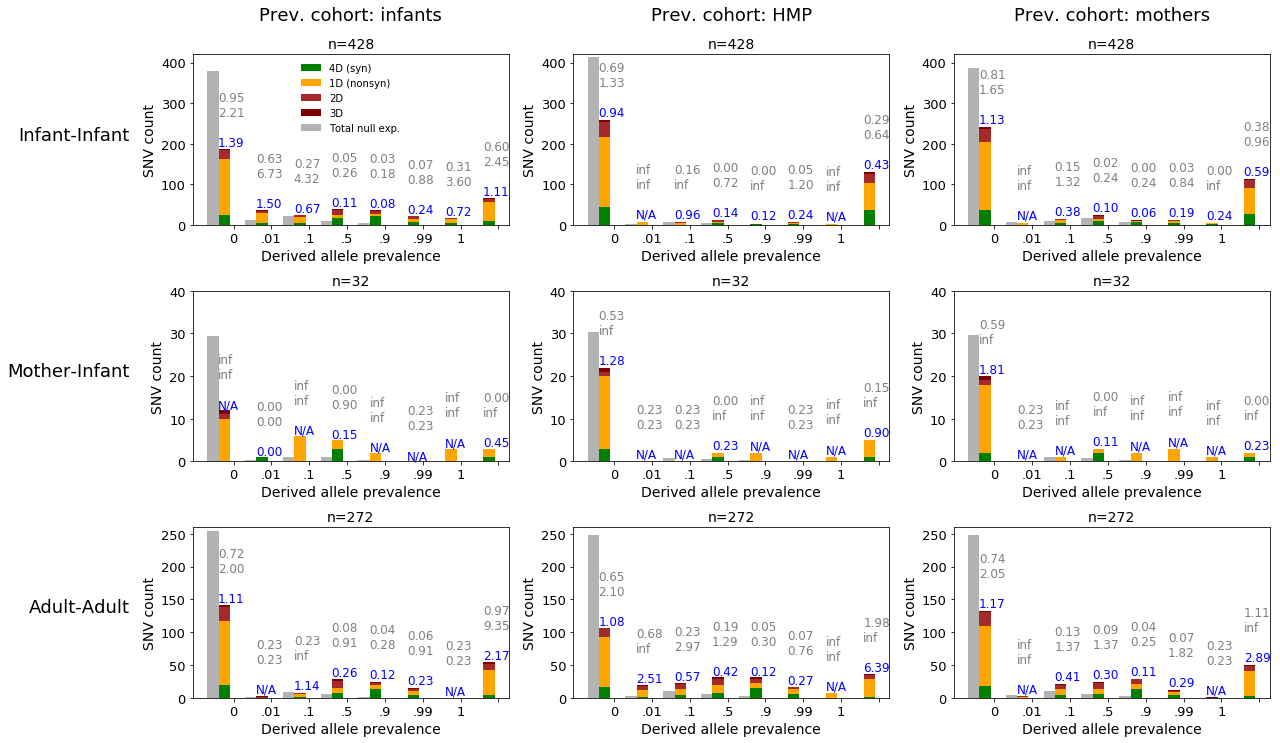

In [14]:
# the whole shebang (format 2)
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3, 3, figsize=(16, 10)) # sharey='row' # originally (12, 10) for 3 x 2
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}
variant_type_pretty_dict = {'1D': '1D (nonsyn)', '2D': '2D', '3D': '3D', '4D': '4D (syn)'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp', 'mother']

num_bootstraps = 10000

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:
        
        # Get and plot actual counts
        cum_bin_counts = np.zeros(len(derived_virtual_freqs))        
        for variant_type in ['4D', '1D', '2D', '3D']:
            bin_counts = prev_distribution[prev_cohort][tp_type][variant_type]
            ax[i][j].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=0.3, align='center', color=colors[variant_type])
            cum_bin_counts += bin_counts
        
        # Get and plot null expectation
        null_bin_counts = null_prev_distribution[prev_cohort][tp_type]        
        ax[i][j].bar(derived_virtual_freqs-0.3, null_bin_counts, width=0.3, align='center', color='0.7')
        
        # Get dN/dS values
        dNs = []
        for nonsyn_opps, nonsyn_count in zip(nonsyn_opps_distribution_alt[prev_cohort][tp_type], prev_distribution[prev_cohort][tp_type]['1D']):
            if nonsyn_opps <= 0:
                dNs.append('N/A')
                continue
            dNs.append(float(nonsyn_count)/float(nonsyn_opps))
        
        dSs = []
        for syn_opps, syn_count in zip(syn_opps_distribution_alt[prev_cohort][tp_type], prev_distribution[prev_cohort][tp_type]['4D']):
            if syn_opps <= 0:
                dSs.append('N/A')
                continue
            dSs.append(float(syn_count)/float(syn_opps))
        
        dNdSs = []
        for dN, dS in zip(dNs, dSs):
            try:
                dNdSs.append('%.02f' % (dN/float(dS)))
            except:
                dNdSs.append('N/A') # Dummy number
        
        # Get bootstrapped dN/dS values
        non_ns = prev_distribution[prev_cohort][tp_type]['1D']
        syn_ns = prev_distribution[prev_cohort][tp_type]['4D']
        non_opportunities = nonsyn_opps_distribution_alt[prev_cohort][tp_type]
        syn_opportunities = syn_opps_distribution_alt[prev_cohort][tp_type]
        
        total_ns = (non_ns + syn_ns).astype('int64')
        ps = non_ns*1.0/total_ns
        
        bootstrapped_dNdSs = []
        
        for bootstrap_idx in xrange(0,num_bootstraps):
            bootstrapped_non_ns = sample_binomial(total_ns, ps)
            bootstrapped_syn_ns = total_ns - bootstrapped_non_ns
            bootstrapped_dNdSs.append( bootstrapped_non_ns*1.0/bootstrapped_syn_ns / (non_opportunities*1.0/syn_opportunities) )

        bootstrapped_dNdSs = np.sort( bootstrapped_dNdSs, axis=0 )
        bootstrapped_dNdSs_lower = bootstrapped_dNdSs[long(0.025*num_bootstraps),:]
        bootstrapped_dNdSs_upper = bootstrapped_dNdSs[long(0.975*num_bootstraps),:]
                
        # Show dN/dS values
        for k in range(len(dNdSs)):
            dNdS = dNdSs[k]
            dNdS_lower = bootstrapped_dNdSs_lower[k]
            dNdS_upper = bootstrapped_dNdSs_upper[k]
            dNdS_CI_str = '%.02f\n%.02f\n\n' % (dNdS_lower, dNdS_upper)
            dNdS_with_CI_str = '%.02f\n%.02f\n\n%s' % (dNdS_lower, dNdS_upper, dNdS)
            # ax[i][j].text(k-0.1, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), dNdS_with_CI_str, color='gray')
            ax[i][j].text(k-0.16, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), dNdS, fontsize=12, color='blue')
            ax[i][j].text(k-0.16, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), dNdS_CI_str, fontsize=12, color='gray')
        # xtick_labels_with_dNdS = ['%s\ndN/dS:\n%s' % (freq, dNdS) for freq, dNdS in zip(derived_virtual_xticklabels, dNdSs)]
        
        ax[i][j].tick_params(axis='both', which='major', labelsize=13)
        ax[i][j].set_xticks(derived_virtual_freqs + 0.25)
        ax[i][j].set_xticklabels(derived_virtual_xticklabels, fontsize=13)
        ax[i][j].set_ylabel("SNV count", fontsize=14)
        ax[i][j].set_xlabel("Derived allele prevalence", fontsize=14)
        ax[i][j].set_title("n=%i" % sum(cum_bin_counts), fontsize=14)
        if j == 0:
            tp_type_label_dict = {'II': 'Infant-Infant', 'MI': 'Mother-Infant', 'AA': 'Adult-Adult'}
            ax[i][j].text(-0.2, 0.5, tp_type_label_dict[tp_type], fontsize=18, transform=ax[i][j].transAxes, ha='right')
        if i == 0:
            prev_cohort_label_dict = {'nonpremie': 'Prev. cohort: infants',
                                      'hmp': 'Prev. cohort: HMP',
                                      'mother': 'Prev. cohort: mothers'}
            ax[i][j].text(0.5, 1.2, prev_cohort_label_dict[prev_cohort], ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

# ax[0][0].text(1.0, 1.4, "%s sweeps" % sweep_type, ha='center', fontsize=20, transform=ax[0][0].transAxes)
for u in range(len(prev_cohorts)):
    ax[0][u].set_ylim((0,420))
    ax[1][u].set_ylim((0,40))
    ax[2][u].set_ylim((0,260))

# Legend
legend_elements = [Patch(facecolor=colors[vt], label=variant_type_pretty_dict[vt]) for vt in ['4D', '1D', '2D', '3D']] + [Patch(facecolor='0.7', label='Total null exp.')]
ax[0][0].legend(handles=legend_elements, loc='upper center', frameon=False)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()
fig.savefig('%s/modification_snp_prevs_%s.pdf' % (config.analysis_directory, sweep_type), bbox_inches='tight')

In [15]:
prev_distribution['hmp']['II']

{'1D': array([172.,   7.,   4.,   3.,   1.,   3.,   2.,  66.]),
 '2D': array([37.,  0.,  2.,  4.,  0.,  1.,  0., 23.]),
 '3D': array([6., 0., 0., 0., 0., 0., 0., 5.]),
 '4D': array([44.,  0.,  1.,  5.,  2.,  3.,  0., 37.])}

# Gene change prevalences

In [15]:
# V1

prev_cohorts = ['nonpremie', 'hmp']
tp_types = ['II', 'MI', 'AA']

gene_gain_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_gain_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

for prev_cohort in prev_cohorts:
    for desired_tp_type in tp_types:
        
        total_freq_gains = np.zeros(len(gene_freq_bins)-1)*1.0
        total_freq_losses = np.zeros(len(gene_freq_bins)-1)*1.0
        total_null_freq_losses = np.zeros(len(gene_freq_bins)-1)*1.0

        for species in gene_gain_freqs:
            for sample_i, sample_j in gene_gain_freqs[species]:
                tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
                tp_type = tp_pair_to_tp_type(tp_pair)
                if tp_type != desired_tp_type:
                    continue
                for f_dict in gene_gain_freqs[species][(sample_i, sample_j)]:
                    f = f_dict[prev_cohort] if prev_cohort in f_dict else 0
                    f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                    total_freq_gains[f_idx] += 1

        for species in gene_loss_freqs:
            for sample_i, sample_j in gene_loss_freqs[species]:
                tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
                tp_type = tp_pair_to_tp_type(tp_pair)
                if tp_type != desired_tp_type:
                    continue
                for f_dict in gene_loss_freqs[species][(sample_i, sample_j)]:
                    f = f_dict[prev_cohort] if prev_cohort in f_dict else 0
                    f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                    total_freq_losses[f_idx] += 1

        for species in gene_loss_null_freqs:
            for sample_i, sample_j in gene_loss_null_freqs[species]:
                tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
                tp_type = tp_pair_to_tp_type(tp_pair)
                if tp_type != desired_tp_type:
                    continue
                for f_dict in gene_loss_null_freqs[species][(sample_i, sample_j)]:
                    if prev_cohort not in f_dict:
                        continue # ??? TODO
                    for f in f_dict[prev_cohort]:
                        f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                        total_null_freq_losses[f_idx] += (1.0/num_bootstraps)
            
        gene_gain_prev_distribution[prev_cohort][desired_tp_type] = total_freq_gains
        gene_loss_prev_distribution[prev_cohort][desired_tp_type] = total_freq_losses
        gene_loss_null_prev_distribution[prev_cohort][desired_tp_type] = total_null_freq_losses

In [16]:
# V2
prev_cohorts = ['infant', 'hmp']
tp_types = ['II', 'MI', 'AA']

gene_gain_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_gain_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
gene_loss_null_prev_distribution_alt = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

gain_qp_pairs = []
loss_qp_pairs = []

# Note: sometimes gene_gain_freqs[species][(sample_i, sample_j)]
# (or gene_loss_freqs) will not have full set of prev cohorts
# because when the data is being pickled,
# it loops over prev_cohort keys in gene_freq_map
# which is generated for each species and will exclude a prev_cohort
# if gene_freqs returned by core_gene_utils.parse_gene_freqs has length 0
# which will happen if the file doesn't exist or it's just empty
# Indeed, number of species with gene_freqs information is halved
# in hmp/prev_hmp compared to infant/prev_infant

for species in gene_gain_freqs:
    for sample_i, sample_j in gene_gain_freqs[species]:
        
        tp_type = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if tp_type not in tp_types:
            continue
        '''
        # MI: restrict to earliest mother-infant pair per host
        if tp_type == 'MI':
            if sample_i not in mi_earliest_infant_sample_dict[species]:
                continue
            if sample_j != mi_earliest_infant_sample_dict[species][sample_i]:
                continue
        '''
        gain_qp_pairs.append((species, sample_i, sample_j))
        
        for gene_gain_freq_dict in gene_gain_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_gain_freq_dict:
                f = gene_gain_freq_dict[prev_cohort]
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                gene_gain_prev_distribution[prev_cohort][tp_type][f_idx] += 1


for species in gene_loss_freqs:
    for sample_i, sample_j in gene_loss_freqs[species]:
        
        tp_type = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if tp_type not in tp_types:
            continue
        
        # MI: restrict to earliest mother-infant pair per host
        if tp_type == 'MI':
            if sample_i not in mi_earliest_infant_sample_dict[species]:
                continue
            if sample_j != mi_earliest_infant_sample_dict[species][sample_i]:
                continue
        
        loss_qp_pairs.append((species, sample_i, sample_j))
        
        for gene_loss_freq_dict in gene_loss_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_loss_freq_dict:
                f = gene_loss_freq_dict[prev_cohort]
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                gene_loss_prev_distribution[prev_cohort][tp_type][f_idx] += 1
        
        num_bootstraps = 10
        
        for gene_loss_null_freq_dict in gene_loss_null_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_loss_null_freq_dict:
                bootstrapped_fs = gene_loss_null_freq_dict[prev_cohort]
                f = (sum(bootstrapped_fs)/float(num_bootstraps))
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                # gene_loss_null_prev_distribution[prev_cohort][tp_type][f_idx] += 1 # I think this was incorrect
                
                for f in bootstrapped_fs:
                    f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                    gene_loss_null_prev_distribution[prev_cohort][tp_type][f_idx] += (1.0/num_bootstraps)

716.0
716.0000000000309
315.0
314.999999999995
15.0
14.999999999999986
14.0
13.999999999999982
76.0
76.00000000000048
77.0
77.00000000000051


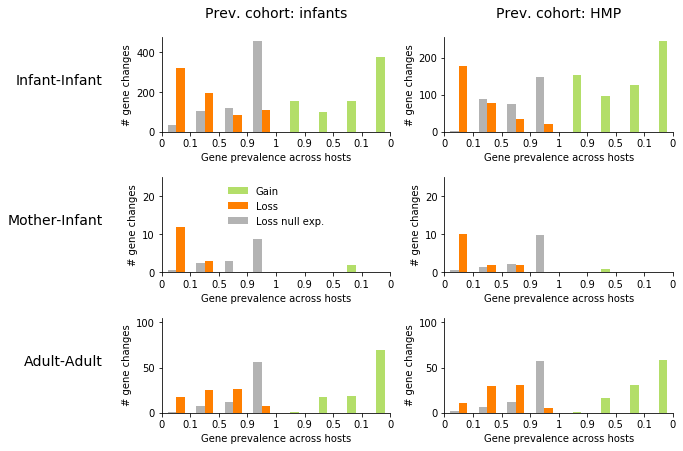

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6)) # sharey='row' # originally (12, 10) for 3 x 2
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:
        
        ax[i][j].spines['top'].set_visible(False); ax[i][j].spines['right'].set_visible(False)
        ax[i][j].get_xaxis().tick_bottom(); ax[i][j].get_yaxis().tick_left() 
        ax[i][j].set_xlabel('Gene prevalence across hosts')
        ax[i][j].set_ylabel('# gene changes')
        ax[i][j].set_xlim([gene_freq_xticks[0],gene_freq_xticks[-1]])
        ax[i][j].set_xticks(gene_freq_xticks)
        ax[i][j].set_xticklabels(gene_freq_xticklabels)
        ax[i][j].plot([0,0],[100,100],'k-')
        
        # Really sloppy but need to change nonpremie to infant for gene info
        prev_cohort = 'infant' if prev_cohort == 'nonpremie' else prev_cohort
        ax[i][j].bar(gene_gain_virtual_freqs+0.15, gene_gain_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0,facecolor='#b3de69',label='gain')
        ax[i][j].bar(gene_loss_virtual_freqs+0.15, gene_loss_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0, facecolor='#ff7f00',label='loss')
        ax[i][j].bar(gene_loss_virtual_freqs-0.3+0.15, gene_loss_null_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0, facecolor='0.7',label='de novo\nexpectation')
        
        print(sum(gene_loss_prev_distribution[prev_cohort][tp_type]))
        print(sum(gene_loss_null_prev_distribution[prev_cohort][tp_type]))
        
        # ax[i][j].set_title("# gains=%i, # losses=%i" % (sum(gene_gain_prev_distribution[prev_cohort][tp_type]), 
        #                                                 sum(gene_loss_prev_distribution[prev_cohort][tp_type])))
        if j == 0:
            tp_type_label_dict = {'II': 'Infant-Infant', 'MI': 'Mother-Infant', 'AA': 'Adult-Adult'}
            ax[i][j].text(-0.26, 0.5, tp_type_label_dict[tp_type], fontsize=14, transform=ax[i][j].transAxes, ha='right')
        if i == 0:
            prev_cohort_label_dict = {'infant': 'Prev. cohort: infants',
                                      'hmp': 'Prev. cohort: HMP'}
            ax[i][j].text(0.5, 1.2, prev_cohort_label_dict[prev_cohort], ha='center', fontsize=14, transform=ax[i][j].transAxes)
        
        ax[1][j].set_ylim((0, 25))
        
        j += 1
    i += 1

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')] + [Patch(facecolor='0.7', label='Loss null exp.')]
ax[1][0].legend(handles=legend_elements, loc='upper center', frameon=False)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()
fig.savefig('%s/modification_gene_prevs_%s.pdf' % (config.analysis_directory, sweep_type), bbox_inches='tight')

In [18]:
# Get statistics for paper

prev_cohort = 'hmp'
tp_type = 'MI'

gene_losses = gene_loss_prev_distribution[prev_cohort][tp_type]
total = sum(gene_losses)
lowprev = gene_losses[0]

print(lowprev/float(total))

0.7142857142857143


In [19]:
def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 

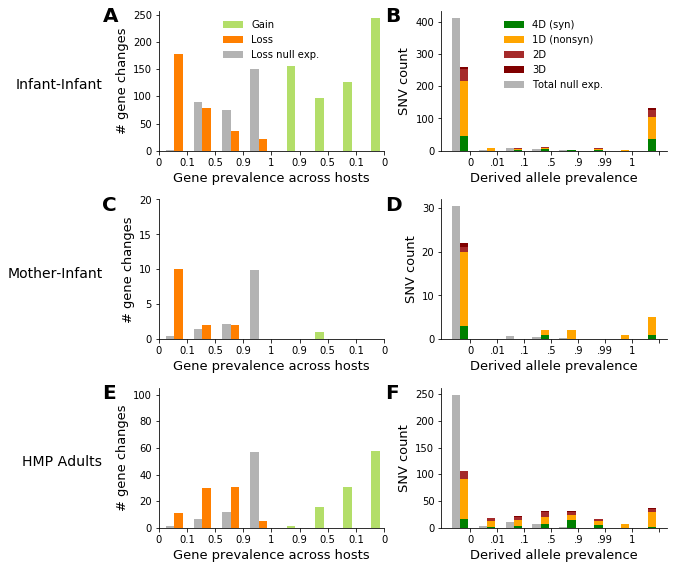

In [20]:
# Final figure

fig, ax = plt.subplots(3, 2, figsize=(8, 8)) # sharey='row' # originally (12, 10) for 3 x 2
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'} # {'1D': '#ff7f00', '4D': '#b3de69', '2D': '#b15928', '3D': '#7c3e1c'}
variant_type_pretty_dict = {'1D': '1D (nonsyn)', '2D': '2D', '3D': '3D', '4D': '4D (syn)'}
letters = {0: {0: 'A', 1: 'B'}, 1: {0: 'C', 1: 'D'}, 2: {0: 'E', 1: 'F'}}

event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
tp_types_pretty_dict = {'II': 'Infant-Infant', 'MI': 'Mother-Infant', 'AA': 'HMP Adults'}
prev_cohorts = ['nonpremie', 'hmp', 'mother']

num_bootstraps = 10000

# First plot prevalence of II, MI, HMP changing SNPs w.r.t. HMP prev cohort

tt_i = 0
for tp_type in tp_types:
    
    prev_cohort = 'hmp' # Just looking at HMP prev cohort
        
    # Get and plot actual counts
    cum_bin_counts = np.zeros(len(derived_virtual_freqs))        
    for variant_type in ['4D', '1D', '2D', '3D']:
        bin_counts = prev_distribution[prev_cohort][tp_type][variant_type]
        ax[tt_i][1].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=0.3, align='center', color=colors[variant_type])
        cum_bin_counts += bin_counts

    # Get and plot null expectation
    null_bin_counts = null_prev_distribution[prev_cohort][tp_type]        
    ax[tt_i][1].bar(derived_virtual_freqs-0.3, null_bin_counts, width=0.3, align='center', color='0.7')
    
    # Labels/formatting
    remove_top_right_spines(ax[tt_i][0])
    ax[tt_i][1].set_xticks(derived_virtual_freqs + 0.25)
    ax[tt_i][1].set_xticklabels(derived_virtual_xticklabels)
    ax[tt_i][1].set_ylabel("SNV count", fontsize=13)
    ax[tt_i][1].set_xlabel("Derived allele prevalence", fontsize=13)
    ax[tt_i][1].text(-0.25, 0.92, letters[tt_i][0], size=20, transform=ax[tt_i][0].transAxes, weight='bold')
    
    # Plot gene gains and losses
    ax[tt_i][0].bar(gene_gain_virtual_freqs+0.2, gene_gain_prev_distribution[prev_cohort][tp_type],
                 width=0.3,linewidth=0,facecolor='#b3de69',label='gain')
    ax[tt_i][0].bar(gene_loss_virtual_freqs+0.2, gene_loss_prev_distribution[prev_cohort][tp_type],
                 width=0.3,linewidth=0, facecolor='#ff7f00',label='loss')
    ax[tt_i][0].bar(gene_loss_virtual_freqs+0.2-0.3, gene_loss_null_prev_distribution[prev_cohort][tp_type],
                 width=0.3,linewidth=0, facecolor='0.7',label='de novo\nexpectation')
    
    # Labels/formatting
    remove_top_right_spines(ax[tt_i][1])
    ax[tt_i][0].set_xlabel('Gene prevalence across hosts', fontsize=13)
    ax[tt_i][0].set_ylabel('# gene changes', fontsize=13)
    ax[tt_i][0].set_xlim([gene_freq_xticks[0],gene_freq_xticks[-1]])
    ax[tt_i][0].set_xticks(gene_freq_xticks)
    ax[tt_i][0].set_xticklabels(gene_freq_xticklabels)
    ax[tt_i][0].plot([0,0],[100,100],'k-')
    ax[tt_i][0].text(-0.25, 0.92, letters[tt_i][1], size=20, transform=ax[tt_i][1].transAxes, weight='bold')
    
    # TP type label on the side
    ax[tt_i][0].text(-0.25, 0.44, tp_types_pretty_dict[tp_type], fontsize=14, ha='right', transform=ax[tt_i][0].transAxes)
    
    tt_i += 1

# Legends
legend_elements = [Patch(facecolor=colors[vt], label=variant_type_pretty_dict[vt]) for vt in ['4D', '1D', '2D', '3D']] + [Patch(facecolor='0.7', label='Total null exp.')]
ax[0][1].legend(handles=legend_elements, loc='upper center', frameon=False)

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')] + [Patch(facecolor='0.7', label='Loss null exp.')]
ax[0][0].legend(handles=legend_elements, loc='upper center', frameon=False)

ax[1][0].set_ylim((0, 20))

# plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()
fig.savefig('%s/figure_3_v2.pdf' % (config.analysis_directory), bbox_inches='tight')
fig.savefig('%s/figure_3_v2.png' % (config.analysis_directory), dpi=500, bbox_inches='tight')

In [ ]:
alt_num_snp_changes_by_tp_type = defaultdict(int)

for tp_type in prev_distribution['hmp']:
    for variant_type in prev_distribution[prev_cohort][tp_type]:
        alt_num_snp_changes_by_tp_type[tp_type] += sum(prev_distribution[prev_cohort][tp_type][variant_type])

print(alt_num_snp_changes_by_tp_type)

In [21]:
# Heatmap of how SNP changes change from adult prev to infant prev

desired_event_type = 'modification'
tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']
variant_types = ['4D', '1D', '2D', '3D']

# List of (hmp_f_idx, nonpremie_f_idx, weight) tuples for each SNP change
prev_compare_distribution = {tp_type: [] for tp_type in tp_types}
null_prev_compare_distribution = {tp_type: [] for tp_type in tp_types}

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_type = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if tp_type not in tp_types:
            continue
        
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        '''
        
        for tup1, tup2 in zip(npdict['hmp'], npdict['nonpremie']):
            f1, weight1 = tup1; f2, weight2 = tp2
            f1_idx = get_f_idx(f1); f2_idx = get_f_idx(f2)
            null_prev_compare_distribution[tp_type].append((f1_idx, f2_idx, weight))
        '''
        
        # Loop over SNP changes
        for vartype, fdict, opp_dict in pdicts:
            prev_compare_distribution[tp_type].append((get_f_idx(fdict['hmp']), get_f_idx(fdict['nonpremie']), 1))

In [22]:
prev_compare_matrix = {tp_type: np.zeros((len(derived_virtual_freqs), len(derived_virtual_freqs))) for tp_type in tp_types}

for tp_type in tp_types:
    
    for f_idx_hmp, f_idx_nonpremie, weight in prev_compare_distribution[tp_type]:
        
        # HMP idx selects the row, nonpremie selects column
        
        prev_compare_matrix[tp_type][f_idx_hmp][f_idx_nonpremie] += weight

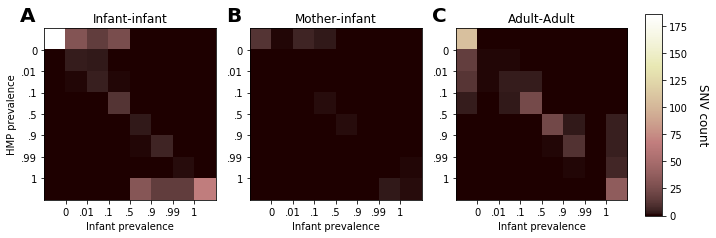

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

vmin = 0
vmax = 186

im0 = ax[0].imshow(prev_compare_matrix['II'], cmap='pink', vmin=vmin, vmax=vmax)
ax[0].set_title("Infant-infant")
ax[0].set_xlabel("Infant prevalence")
ax[0].set_xticks(derived_virtual_freqs[:-1]+0.5)
ax[0].set_xticklabels(derived_virtual_xticklabels)
ax[0].set_yticks(derived_virtual_freqs[:-1]+0.5)
ax[0].set_yticklabels(derived_virtual_xticklabels)
ax[0].set_ylabel("HMP prevalence")
ax[0].text(-0.14, 1.04, 'A', size=20, transform=ax[0].transAxes, weight='bold')

im1 = ax[1].imshow(prev_compare_matrix['MI'], cmap='pink', vmin=vmin, vmax=vmax)
ax[1].set_title("Mother-infant")
ax[1].set_xlabel("Infant prevalence")
ax[1].set_xticks(derived_virtual_freqs[:-1]+0.5)
ax[1].set_xticklabels(derived_virtual_xticklabels)
ax[1].set_yticks(derived_virtual_freqs[:-1]+0.5)
ax[1].set_yticklabels(derived_virtual_xticklabels)
# ax[1].set_ylabel("HMP prevalence")
ax[1].text(-0.14, 1.04, 'B', size=20, transform=ax[1].transAxes, weight='bold')

im2 = ax[2].imshow(prev_compare_matrix['AA'], cmap='pink', vmin=vmin, vmax=vmax)
ax[2].set_title("Adult-Adult")
ax[2].set_xlabel("Infant prevalence")
ax[2].set_xticks(derived_virtual_freqs[:-1]+0.5)
ax[2].set_xticklabels(derived_virtual_xticklabels)
ax[2].set_yticks(derived_virtual_freqs[:-1]+0.5)
ax[2].set_yticklabels(derived_virtual_xticklabels)
# ax[2].set_ylabel("HMP prevalence")
ax[2].text(-0.14, 1.04, 'C', size=20, transform=ax[2].transAxes, weight='bold')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cbar_ax)
ax[2].text(1.4, 0.62, 'SNV count', transform=ax[2].transAxes, rotation=270, fontsize=12)

plt.show()
fig.savefig('%s/hmp_vs_infant_prev_heatmaps.pdf' % (config.analysis_directory), bbox_inches='tight')
fig.savefig('%s/hmp_vs_infant_prev_heatmaps.png' % (config.analysis_directory), dpi=500, bbox_inches='tight')

In [43]:
derived_virtual_xticklabels

['0', '.01', '.1', '.5', '.9', '.99', '1']

In [52]:
derived_virtual_freqs

array([0, 1, 2, 3, 4, 5, 6, 7])